In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib import cm
from mud.base import *
from mud.examples import polynomial_1D, random_linear_problem, random_linear_wme_problem
from mud.plot import comparison_plot
from mud.util import rank_decomposition
from scipy.stats import norm

__author__ = "Carlos del-Castillo-Negrete"
__copyright__ = "Carlos del-Castillo-Negrete"
__license__ = "mit"

plt.backend = "Agg"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{bm}"

_logger = logging.getLogger(__name__)


def _save_fig(
    fname: str, save_path: str = None, dpi: int = 500, close_fig: bool = True
):
    """
    Save Figure Utility

    Utility to save figure to a given folder path if specified.

    Parameters
    ----------
    fname: str
        Name of image, with extension.
    save_path: str, optional
        Directory to save figure to. Assumed to exist. If not specified then the
        figure is saved to the current working directory.
    dpi: int, default=500
        Resolution to save image with.
    close_fig: bool, default=True
        Whether to close the figure after saving it.


    """
    if save_path is not None:
        fname = Path(save_path) / fname
        plt.savefig(str(fname), dpi=dpi)
    if close_fig:
        plt.close()


def run_comparison_example(
    N_vals: List[int] = [1, 5, 10, 20],
    plot_version: int = 1,
    save_path: str = None,
    dpi: int = 500,
    close_fig: bool = True,
    **kwargs,
):

    """
    Run Simple Example

    Entry-point function for running simple polynomial example comparing Bayesian
    and Data-Consistent solutions.

    Parameters
    ----------
    plot_version: int, default=1
        Version of plot labels to use. Set to 1 for english names in legends.
        Any other value will result in LaTex symbols for the legend.
    save_path: str, optional
        If provided, path to save the resulting figure to.
    kwargs: dict, optional
        Additional keyword arguments will be passed to
    :func:`mud.examples.polynomial_1D` to override defaults for problem set-up.

    Returns
    -------
    res: Tuple[:class:`mud.base.DensityProblem`, :class:`mud.base.BayesProblem`, :class:`matplotlib.axes.Axes`]
        Tuple of ``(d_prob, b_prob, ax)`` containing the resulting Density and
        Bayesian problem classes in ``d_prob`` and ``b_prob``, resp., and the
        matplotlib axis to which the results were plotted.
    """

    for N in N_vals:
        # Number of samples to use, and assumed observed normal distribution parameters
        def_args = {
            "p": 5,
            "n_samples": int(1e3),
            "mu": 0.25,
            "sigma": 0.1,
            "domain": np.array([[-1, 1]]),
            "N": N,
        }
        def_args.update(kwargs)
        lam, q_lam, data = polynomial_1D(
            **def_args
        )  # p=p, N=N, domain=domain, mu=mu, sigma=sigma, num_data=1)

        # Set up and solve DCI problem
        d_prob = DensityProblem(lam, q_lam, domain=def_args["domain"])
        d_prob.set_observed(norm(loc=np.mean(data), scale=def_args["sigma"]))
        d_prob.estimate()

        # Set up and solve Bayesian problem
        bayes = BayesProblem(lam, q_lam, domain=def_args["domain"])
        bayes.set_likelihood(norm(loc=data, scale=def_args["sigma"]))
        bayes.estimate()

        ax = comparison_plot(d_prob, bayes, space="param", plot_version=plot_version)
        if N != 1:
            _ = ax.text(-0.75, 5, f"N = {N}", fontsize=22)
            _ = ax.set_ylim([-0.2, 28.0])
        _save_fig(
            f"bip-vs-sip-{N}.png", save_path=save_path, dpi=dpi, close_fig=close_fig
        )

        ax = comparison_plot(d_prob, bayes, space="obs", plot_version=plot_version)
        if N != 1:
            _ = ax.text(-0.75, 5, f"N = {N}", fontsize=22)
            _ = ax.set_ylim([-0.2, 28.0])
        _save_fig(
            f"bip-vs-sip-pf-{N}.png", save_path=save_path, dpi=dpi, close_fig=close_fig
        )


def run_contours(
    save_path: str = None, dpi: int = 500, close_fig: bool = True, **kwargs
):
    """ """

    # Build linear problem - Overwrite defaults with anything in **kwargs
    def_args = {
        "A": np.array([[1, 1]]),
        "b": np.array([[0]]),
        "y": np.array([[1]]),
        "mean_i": np.array([[0.25, 0.25]]).T,
        "cov_i": np.array([[1, -0.25], [-0.25, 0.5]]),
        "cov_o": np.array([[1]]),
    }
    def_args.update(kwargs)
    lin_prob = LinearGaussianProblem(**def_args)

    mud_sol, map_sol, ls_sol = (
        lin_prob.solve("mud"),
        lin_prob.solve("map"),
        lin_prob.solve("ls"),
    )

    # Plot data mismatch contours
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Plot contour map for data mismatch term
    lin_prob.plot_fun_contours(
        ax=ax, terms="data", levels=50, cmap=cm.viridis, alpha=1.0
    )

    # Plot solution contour for 2-1 map, going through least squares solution as the reference point.
    lin_prob.plot_contours(
        ax=ax,
        annotate=True,
        note_loc=[0.1, 0.9],
        label="Solution Contour",
        plot_opts={"color": "r"},
        annotate_opts={"fontsize": 20, "backgroundcolor": "w"},
    )

    # Plot solution contour for 2-1 map, going through least squares solution as the reference point.
    ax.axis("equal")

    _ = ax.set_xlim([0, 1])
    _ = ax.set_ylim([0, 1])

    _save_fig(
        "data_mismatch_contour.png", save_path=save_path, dpi=dpi, close_fig=close_fig
    )

    # Plot Regularization
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    lin_prob.plot_fun_contours(
        ax=ax, terms="reg", levels=50, cmap=cm.viridis, alpha=1.0
    )
    lin_prob.plot_sol(
        ax=ax,
        point="initial",
        label="Initial Mean",
        pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
    )
    _ = ax.axis([0, 1, 0, 1])
    _save_fig("tikonov_contour.png", save_path=save_path, dpi=dpi, close_fig=close_fig)

    # Plot Modified Regularization
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    lin_prob.plot_fun_contours(
        ax=ax, terms="reg_m", levels=50, cmap=cm.viridis, alpha=1.0
    )
    lin_prob.plot_sol(
        ax=ax,
        point="initial",
        label="Initial Mean",
        pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
    )
    _ = ax.axis([0, 1, 0, 1])
    _save_fig(
        "consistent_contour.png", save_path=save_path, dpi=dpi, close_fig=close_fig
    )

    # Plot contour map for functional for Bayesian Posteriror
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    lin_prob.plot_fun_contours(ax=ax, terms="bayes", levels=50, cmap=cm.viridis)

    # Plot initial mean point
    lin_prob.plot_sol(
        ax=ax,
        point="initial",
        pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 20},
    )

    # Plot Least Squares Solution
    lin_prob.plot_sol(
        ax=ax,
        point="ls",
        label="Least Squares",
        note_loc=[0.49, 0.55],
        pt_opts={"color": "xkcd:blue", "s": 100, "marker": "d", "zorder": 10},
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    # Plot MAP Solution
    lin_prob.plot_sol(
        ax=ax,
        point="map",
        label="MAP",
        pt_opts={
            "color": "tab:orange",
            "s": 100,
            "linewidths": 3,
            "marker": "x",
            "zorder": 10,
        },
        ln_opts=None,
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    # Plot solution contour for 2-1 map, going through least squares solution as the reference point.
    lin_prob.plot_contours(
        ax=ax,
        annotate=False,
        note_loc=[0.1, 0.9],
        label="Solution Contour",
        plot_opts={"color": "r"},
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    _ = ax.axis([0, 1, 0, 1])
    _save_fig(
        "classical_solution.png", save_path=save_path, dpi=dpi, close_fig=close_fig
    )

    # Plot contour map for functional for Updated Density
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    lin_prob.plot_fun_contours(ax=ax, terms="dc", levels=50, cmap=cm.viridis)

    # Plot initial mean point
    lin_prob.plot_sol(
        ax=ax,
        point="initial",
        pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 20},
    )

    # Plot Least Squares Solution and line from initial to it
    lin_prob.plot_sol(
        ax=ax,
        point="ls",
        label="Least Squares",
        note_loc=[0.49, 0.55],
        pt_opts={"color": "k", "s": 100, "marker": "d", "zorder": 10},
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    # Plot MUD Solution
    lin_prob.plot_sol(
        point="mud",
        ax=ax,
        label="MUD",
        pt_opts={"color": "k", "s": 100, "marker": "*", "zorder": 10},
        ln_opts={"color": "k", "marker": "*", "lw": 1, "zorder": 10},
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    # Plot solution contour for 2-1 map, going through least squares solution as the reference point.
    lin_prob.plot_contours(
        ax=ax,
        annotate=False,
        note_loc=[0.1, 0.9],
        label="Solution Contour",
        plot_opts={"color": "r"},
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    ax.axis("equal")
    _ = ax.axis([0, 1, 0, 1])
    _save_fig(
        "consistent_solution.png", save_path=save_path, dpi=dpi, close_fig=close_fig
    )


def run_comparison_contours(
    save_path: str = None, dpi: int = 500, close_fig: bool = True, **kwargs
):
    """
    Run Comparison Plot Example

    Produces Figure 5 in paper, comparing MUD, MAP, and least squares solution
    contours for the linear gaussian problem:


    """

    # Build linear problem - Overwrite defaults with anything in **kwargs
    def_args = {
        "A": np.array([[1, 1]]),
        "b": np.array([[0]]),
        "y": np.array([[1]]),
        "mean_i": np.array([[0.25, 0.25]]).T,
        "cov_i": np.array([[1, -0.5], [-0.5, 0.5]]),
        "cov_o": np.array([[0.5]]),
        "alpha": 1.0,
    }
    def_args.update(kwargs)
    lin_prob = LinearGaussianProblem(**def_args)

    mud_sol, map_sol, ls_sol = (
        lin_prob.solve("mud"),
        lin_prob.solve("map"),
        lin_prob.solve("ls"),
    )

    # Plot comparison contour plot of map vs mud solution
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    lin_prob.plot_fun_contours(ax=ax, terms="bayes", levels=50, cmap=cm.viridis)

    # Plot initial mean point
    lin_prob.plot_sol(
        ax=ax,
        point="initial",
        pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
    )

    # Plot Least Squares Solution and line from initial to it
    lin_prob.plot_sol(
        ax=ax,
        point="ls",
        label="Least Squares",
        note_loc=[0.49, 0.55],
        pt_opts={"color": "k", "s": 100, "marker": "d", "zorder": 10},
    )

    # Plot MAP Solution
    lin_prob.plot_sol(
        ax=ax,
        point="map",
        label="MAP",
        pt_opts={
            "color": "tab:orange",
            "s": 100,
            "linewidth": 3,
            "marker": "x",
            "zorder": 10,
        },
        ln_opts=None,
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    # Plot MUD Solution
    lin_prob.plot_sol(
        point="mud",
        ax=ax,
        label="MUD",
        pt_opts={"color": "k", "s": 100, "linewidth": 3, "marker": "*", "zorder": 10},
        ln_opts={"color": "k", "marker": "*", "lw": 1, "zorder": 10},
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    # Plot solution contour for 2-1 map, going through least squares solution as the reference point.
    lin_prob.plot_contours(
        ax=ax,
        annotate=False,
        note_loc=[0.1, 0.9],
        label="Solution Contour",
        plot_opts={"color": "r"},
        annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
    )

    # Plot "Reference" parameter
    ax.scatter([0.7], [0.3], color="k", s=100, marker="s", zorder=11)
    _ = ax.axis([0, 1, 0, 1])
    _save_fig(
        "map_compare_contour.png", save_path=save_path, dpi=dpi, close_fig=close_fig
    )


def run_wme_covariance_example(
    save_path: str = None,
    dpi: int = 500,
    close_fig: bool = True,
    dim_input: int = 20,
    dim_output: int = 5,
    sigma: float = 1e-1,
    Ns: List[int] = [10, 100, 1000, 10000],
    seed: int = 21,
):

    if seed is not None:
        np.random.seed(seed)

    initial_cov = np.diag(np.sort(np.random.rand(dim_input))[::-1] + 0.5)
    lam_ref = np.random.randn(dim_input).reshape(-1, 1)

    # Create operator list of random linear problems
    operator_list, data_list, _ = random_linear_problem(
        lam_ref,
        [0] * dim_output,  # noiseless data bc we want to simulate multiple trials
        num_qoi=dim_output,
        num_observations=[max(Ns)]
        * dim_output,  # want to iterate over increasing measurements
        dist="norm",
        repeated=True,
    )

    fig, ax = plt.subplots(figsize=(10, 5))
    index_values = np.arange(dim_input) + 1
    lines = ["solid", "dashed", "dashdot", "dotted"]

    noise_draw = np.random.randn(dim_output, max(Ns)) * sigma
    for j, N in enumerate(Ns):

        # Sub-select over increasing measurements and add noise
        _oper_list = operator_list  # [M[0:N, :] for M in operator_list]
        _d = np.array([y[0:N] for y in data_list]) + noise_draw[:, 0:N]
        _data_list = _d.tolist()

        # Build Linear WME problem
        linear_wme_prob = LinearWME(_oper_list, _data_list, sigma, cov_i=initial_cov)

        # Solve for updated covariance
        up_cov = linear_wme_prob.updated_cov()
        up_sdvals = sp.linalg.svdvals(up_cov)

        ax.scatter(
            index_values,
            up_sdvals,
            marker="o",
            s=200,
            facecolors="none",
            edgecolors="k",
        )

        ax.plot(
            index_values,
            up_sdvals,
            label=f"$N={N:1.0E}$",
            alpha=1,
            lw=3,
            ls=lines[j % len(lines)],
            c="k",
        )

    _ = ax.set_yscale("log")
    _ = ax.set_xticks(index_values)
    _ = ax.set_xticklabels(ax.get_xticks(), rotation=0)
    _ = ax.set_xlabel("Index")
    _ = ax.set_ylabel("Eigenvalue")
    _ = ax.legend(loc="lower left")

    _save_fig(
        "lin-meas-cov-sd-convergence.png",
        save_path=save_path,
        dpi=dpi,
        close_fig=close_fig,
    )


def run_high_dim_linear(
    save_path: str = None,
    dpi: int = 500,
    close_fig: bool = True,
    dim_input: int = 100,
    dim_output: int = 100,
    seed: int = 21,
):

    lam_ref, randn_high_dim = random_linear_problem(
        dim_input=dim_input, dim_output=dim_output, seed=seed
    )
    A_ranks = rank_decomposition(randn_high_dim.A)

    c = np.linalg.norm(lam_ref)
    err = lambda xs: [np.linalg.norm(x - lam_ref) / c for x in xs]

    dim_errs = []
    rank_errs = []
    alpha_list = [1.0, 0.1, 0.001]
    for alpha in alpha_list:
        r_errs = []
        d_errs = []
        randn_high_dim.alpha = alpha
        for dim in range(1, dim_output + 1, 1):
            # Solve inverse problem for dimensional subset problem
            # Tuple is returned, with (mud, map, least-squares) solutions
            dim_solutions = randn_high_dim.solve(method="all", output_dim=dim)

            # Construct Rank k Linear Problem
            y_rank = A_ranks[dim - 1] @ lam_ref + randn_high_dim.b
            rank_prob = LinearGaussianProblem(
                A_ranks[dim - 1],
                randn_high_dim.b,
                y_rank,
                randn_high_dim.mean_i,
                randn_high_dim.cov_i,
                alpha=alpha,
            )
            rank_solutions = rank_prob.solve(method="all")

            # Compute errors
            d_errs.append(np.array(err(dim_solutions)))
            r_errs.append(np.array(err(rank_solutions)))

        dim_errs.append(np.array(d_errs))
        rank_errs.append(np.array(r_errs))

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    x = np.arange(1, dim_output, 1)
    for idx, alpha in enumerate(alpha_list):
        # Plot convergence for MUD Solutions
        ax.plot(x, dim_errs[idx][:, 0][:-1], label="MUD", c="k", lw=10)

        # Plot convergence plot for MAP Solutions - Annotate for different alphas
        ax.plot(x, dim_errs[idx][:, 1][:-1], label="MAP", c="r", ls="--", lw=5)
        ax.annotate(
            f"$\\alpha$={alpha:1.2E}",
            (100, max(dim_errs[idx][:, 1][-1], 0.01)),
        )

        # Plot convergence for Least Squares Solutions
        ax.plot(
            x,
            dim_errs[idx][:, 2][:-1],
            label="LSQ",
            c="xkcd:light blue",
            ls="-",
            lw=5,
            zorder=10,
        )

    # Label plot
    _ = ax.set_title(
        "Convergence for Various $\\Sigma_{init} = \\alpha \\Sigma$",
    )
    _ = ax.set_ylim(0, 1.0)
    _ = ax.set_ylabel("Relative Error")
    _ = ax.set_xlabel("Dimension of Output Space")
    _ = ax.legend(["MUD", "MAP", "Least Squares"])

    _save_fig(
        "lin-dim-cov-convergence.png",
        save_path=save_path,
        dpi=dpi,
        close_fig=close_fig,
    )

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for idx, alpha in enumerate(alpha_list):
        # Plot convergence for MUD Solutions
        ax.plot(x, rank_errs[idx][:, 0][:-1], label="MUD", c="k", lw=10)

        # Plot convergence plot for MAP Solutions - Annotate for different alphas
        ax.plot(x, rank_errs[idx][:, 1][:-1], label="MAP", c="r", ls="--", lw=5)
        ax.annotate(
            f"$\\alpha$={alpha:1.2E}",
            (100, max(rank_errs[idx][:, 1][-1], 0.01)),
        )

        # Plot convergence for Least Squares Solutions
        ax.plot(
            x,
            rank_errs[idx][:, 2][:-1],
            label="LSQ",
            c="xkcd:light blue",
            ls="-",
            lw=5,
            zorder=10,
        )

    # Label plot
    _ = ax.set_title(
        "Convergence for Various $\\Sigma_{init} = \\alpha \\Sigma$",
    )
    _ = ax.set_ylim(0, 1.0)
    _ = ax.set_ylabel("Relative Error")
    _ = ax.set_xlabel("Rank(A)")
    _ = ax.legend(["MUD", "MAP", "Least Squares"])

    _save_fig(
        "lin-rank-cov-convergence.png",
        save_path=save_path,
        dpi=dpi,
        close_fig=close_fig,
    )

In [2]:
%matplotlib widget

<a id='Title'></a>
# <center> Parameter Identification with Maximal Updated Densities: Existence, Uniqueness, and Convergence
_____


<center>
    Troy Butler, Michael Pilosov, and Tian Yu Yen
    <br>
</center>
    
<center>
    Notebook by:
    <br>
    Carlos del-Castillo-Negrete (<font color='blue'>cdelcastillo21@gmail.com</font>)
</center>


# Comparing Inverse Problems and Solution

This notebook is in ended to supplement [ref] section 2 covering differences in problem formulation and solutions between Bayesian and Data-Consistent Inversion. 
:set number


## Comapring Solutions Solutions

* Data-Consistent: 

    $\Large \pi_{up}(\lambda) = \pi_{in}(\lambda)\frac{\pi_{ob}(Q(\lambda))}{\pi_{pred}(Q(\lambda))}$

* Bayesian:

    $\Large \pi_{post}(\lambda | d) = \frac{\pi_{prior}(\lambda)\pi_{like}(d | \lambda)}{\int_{\Lambda}\pi_{prior}(\lambda)\pi_{like}(d | \lambda)}$


Note:

* Prior density $\pi_{prior}$ represents an initial description of the epistemic, or reducible, uncertainty on $\Lambda$ in the Bayesian framework, while $\pi_{in}$ represents initial descripton of aleatoric, or irreducible, uncertainty on $\Lambda$.

* Form for Bayesian comes from Bayes rule [ref] while form for Data-Consistent comes from Disintegration theorem and Bayes rule [ref].

* The data-likelihood in the Bayesian framework, $\pi_{like}(d | \lambda)$, plays a role in the normalizing constant of the Bayesian solution, while the observed density $\pi_{ob}(Q(\lambda))$ does not in the Data-Consistent framework. 


## Example 1 - Low Dimensional Example

We start with a simple QoI map over a one-dimensional parameter space:
   
   $\Lambda = [-1, 1] \in \mathbb{R}$  
   
   $Q(\lambda) = \lambda^5 \rightarrow \mathcal{D} = [-1, 1]$

We will frame the Data-Consistent and Bayesian inverse problems for this particular case as similarily as possilbe, to show that even when we do so the two frameworks solve fundamentally different inverse problems.

### Data

We take $N$ samples from an initial uniform distribution over the input parameter space. These samples will be pushed forward through our QoI map to constrcut the data likelihood $\pi_{like}$ for the Bayesian framework and the predicted density $\pi_{pred}$ for the Data-Consistent Framework. 

In [3]:
seed = 123456

# Number of samples to use, and assumed observed normal distribution parameters
p, n_samples, mu, sigma, domain = 5, int(1e3), 0.25, 0.1, np.array([[-1, 1]])
lam, q_lam, data = polynomial_1D(
    p=p, n_samples=n_samples, domain=domain, mu=mu, sigma=sigma, N=1
)

### Data Consistent Approach

For the Data-Consistent framework we assume:

   $\pi_{in} \sim \mathcal{U}([-1, 1])$
  
   $\pi_{ob} \sim \mathcal{N}(0.25,0.1^2)$

In [4]:
# Construct density problem object using lambda samples and QoI Values
# Note by default DensityProblem class assumes uniform distribution over domain if nothing specified
# The predicted distribution will be determined from a Gaussian Kernel Density Estimate over predicted values
# Have to set observed distribution -> assuming known sample mean, 0.25, and std dev, 0.1, from observed data.
d_prob = DensityProblem(lam, q_lam, domain=domain)
d_prob.set_observed(norm(loc=mu, scale=sigma))

# Get Maximal Updated Density (MUD) point estimate
d_prob.estimate()

array([0.7838779])

### Bayesian Approach

Bayesian - Epistemic Uncertainty - Assumptions:

   For all $d \in \mathcal{D}, d = Q(\lambda^\dagger) + \xi, \xi \sim N (0,0.1^2)$
   
   $\pi_{prior} \sim \mathcal{U}([-1, 1])$
   
   Build $\pi_{post}(d | \lambda)$ assuming observed value of $d = 0.25$, leading to likelihood that matches observed distribution $N(0.25, 0.1^2)$.

In [5]:
# Construct bayesian problem object using lambda samples and QoI Values
# Fit using observed data to construct data-likelihood
bayes = BayesProblem(lam, q_lam, domain=domain)
bayes.set_likelihood(norm(loc=mu, scale=sigma))
bayes.estimate()

array([0.75840149])

### Comparison Plots

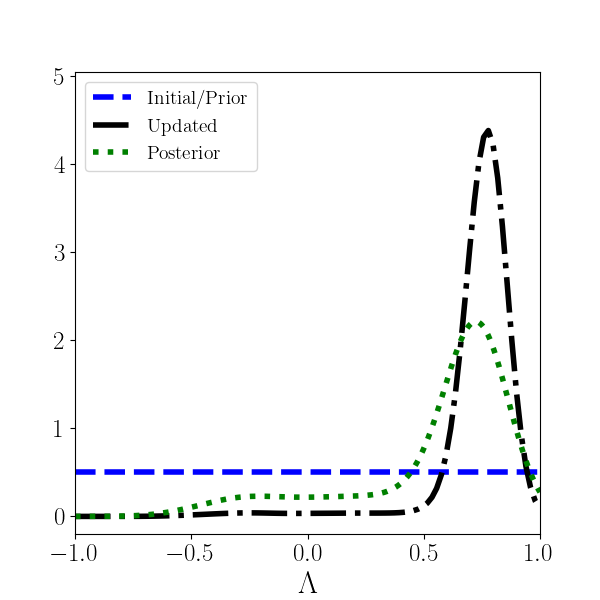

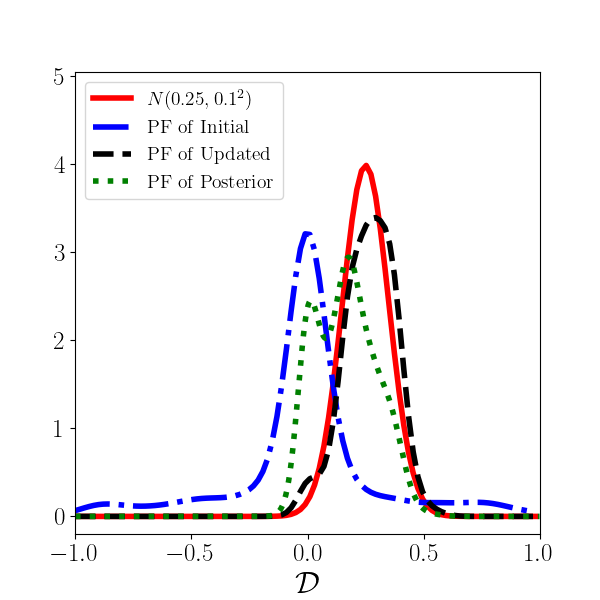

In [6]:
plt.close("all")
_ = run_comparison_example(N_vals=[1], plot_version=1, save_path=None, close_fig=False)

# Data-Constructed QoI Maps 1: The Repeated Measurements Case

This notebook is intended to supplement [ref] section 5 where data-constructed Quantity of Interest (QoI) Maps are explored.

## Notation and Illustrative Example

Assuming $d$ measurement devices for which repeated noisy data are obtained, let:

* $\mathcal{M}_j(\lambda^\dagger) = $ the $j$th measurement device, for each $1\leq j\leq d$.

* $N_j = $ the number of noisy data obtained for each device.

* $d_{j,i} = $ the $i$th noisy datume from $j$th measurement device, where $1\leq i \leq N_j$. 

Assuming unbiased additive error model for the measurement noise with i.i.d. Gaussian errors, we have:
    
$d_{j,i} = \mathcal{M}_j(\lambda^\dagger) + \xi_i, \xi_i \sim N(0,\sigma_j^2), 1\leq i \leq N_j$

Returning to problem from section 2:

   $\Lambda = [-1, 1] \in \mathbb{R}$  
   
   $Q(\lambda) = \lambda^5 \rightarrow \mathcal{D} = [-1, 1]$


Before, we only talked about how predicted data pushed through a model is used to solve the Bayesian and Stochastic Inversion Problems. For the Bayesian Inversion problem, it is clear that osberved data are used to construct the data-likelihood function $\pi_{post}(\lambda|d)$. The question now becomes how do we incorporate real observed data within the SIP framework. Before, in the SIP
 
For Bayesian Problem - Data are used to construct the data-likelihood function $\pi_{post}(\lambda|d)$

For SIP - We assumed the the observed distribution, $\pi_{ob}$ came from a $\mathcal{N}(0.25,0.1^2)$ distribution. 


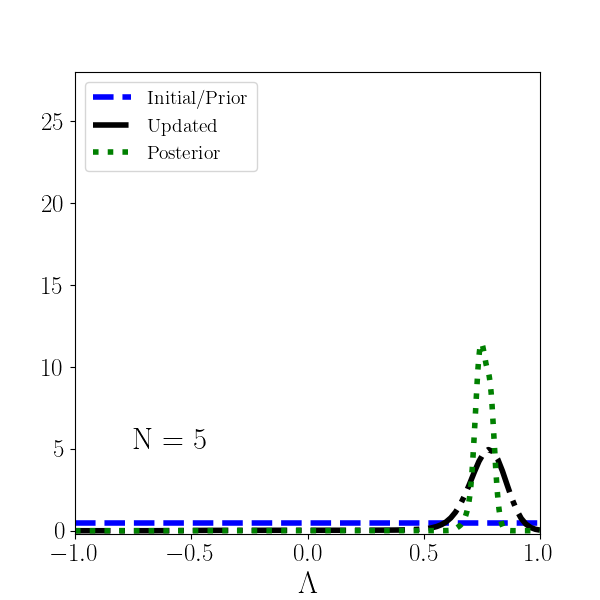

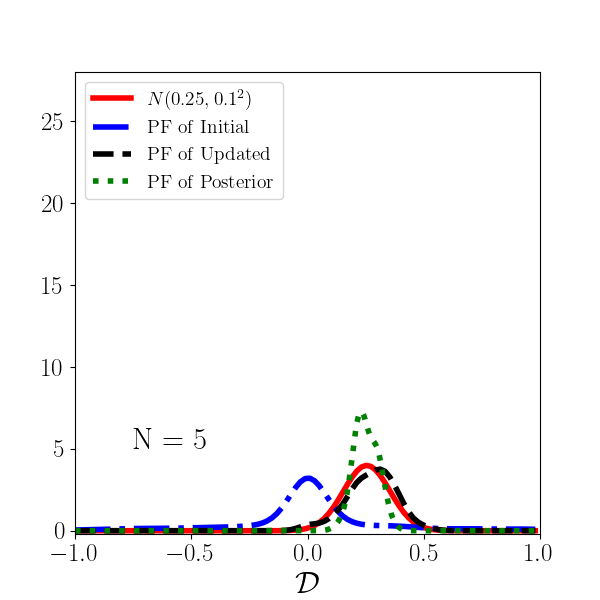

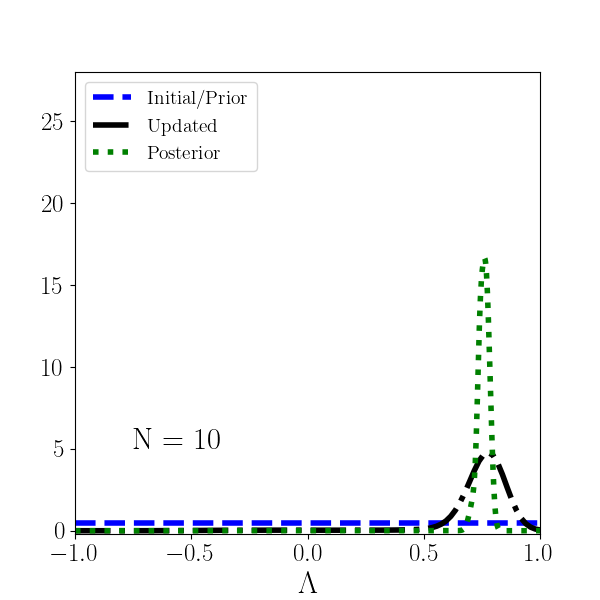

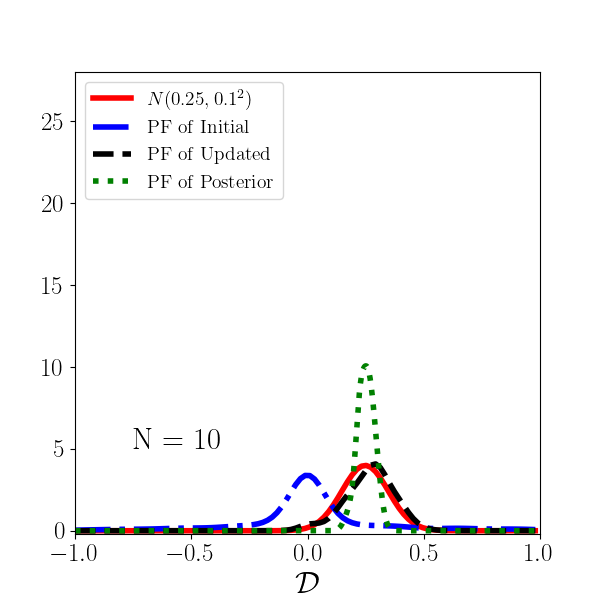

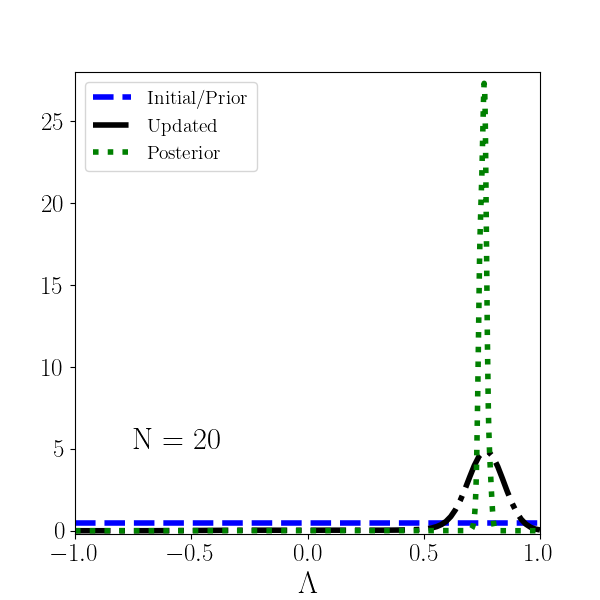

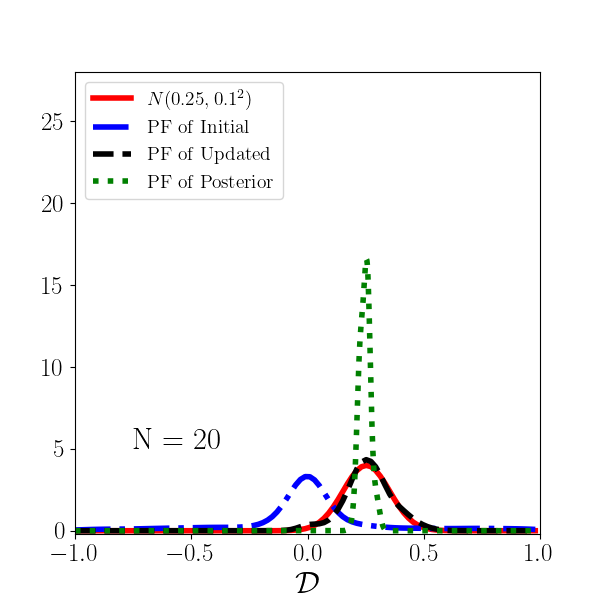

In [7]:
plt.close("all")
_ = run_comparison_example(
    N_vals=[5, 10, 20], plot_version=1, save_path=None, close_fig=False
)

## The Weighted Mean Error Map

TODO: Include motivation for Q_WME based off of statistica l sufficiency 

$ \Large Q_{WME,k}(\lambda) := \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{\mathcal{M}_j(\lambda) - d_{j,i}}{\sigma_j} $

## The Weighted Mean Error Map for Linear Maps

TODO: Derivation

$ \Large Q_{WME}(\lambda) = A(\mathbf{N})\lambda + b(\mathbf{N}) $ 

Where $j$th component of $\mathbf{N} \in \mathbb{R}^d$ is given by $N_j$

The $j$th row of $A(\mathbf{N})\in\mathbb{R}^{d\times p}$ by:

$ \Large A_j = \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{M_j}{\sigma_j} = \frac{N_j}{\sigma_j}M_j$

The $j$th component of $b(\mathbf{N})\in\mathbb{R}^d$ by:

$ \Large b_j(N) = - \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{d_{j,i}}{\sigma_j} $ 

# Linear Theory of MUD points


## Problem and Assumptions

In this section we assume linear (or affine) QoI maps with Gaussian distributions and compare the analytical solutions given by the Bayesian and Data-Consistent Framework:

$Q(\lambda) = A\lambda + \mathbf{b}, A \in \mathbb{R}^{d\times p}$,

For the Bayesian framework, assume 

$\pi_{prior} = \mathcal{N}(\lambda_0,\Sigma_{init}), \pi_{obs} = \mathcal{N}({\bf y}, \Sigma_{obs})$.

Our analytical MAP point is given by (eq. ref in paper):

$\lambda^{MAP} = \lambda_0 + \Sigma_{post}A^T\Sigma_{obs}^{-1}(\mathbf{y} - \mathbf{b} - A\lambda_0), 
 \Sigma_{post} := (A^T\Sigma_{obs}^{-1}A + \Sigma_{init}^{-1})^{-1}$

For the Data-Consistent framework, assume

$\pi_{in} = \mathcal{N}(\lambda_0,\Sigma_{init}), \pi_{obs} = \mathcal{N}({\bf y}, \Sigma_{obs})$.

Our analytical MUD point is given by (eq. ref in paper):

$\lambda^{MUD} = \lambda_0 + \Sigma_{init}A^T\Sigma_{pred}^{-1}(\mathbf{y} - \mathbf{b} - A\lambda_0), 
 \Sigma_{pred} := A\Sigma_{init}A^T$


## Low Dimensional Example

Problem Set-Up:

$A = \begin{bmatrix} 1 & 1 \end{bmatrix}, b = 0, y = 1$

$\lambda_0 = \begin{bmatrix} 0.25 & 0.25 \end{bmatrix}^T,
\Sigma_{init} = \begin{bmatrix} 1 & -0.25 \\ -0.25 & 0.5 \end{bmatrix},
\Sigma_{obs} = \begin{bmatrix} 0.25 \end{bmatrix}$

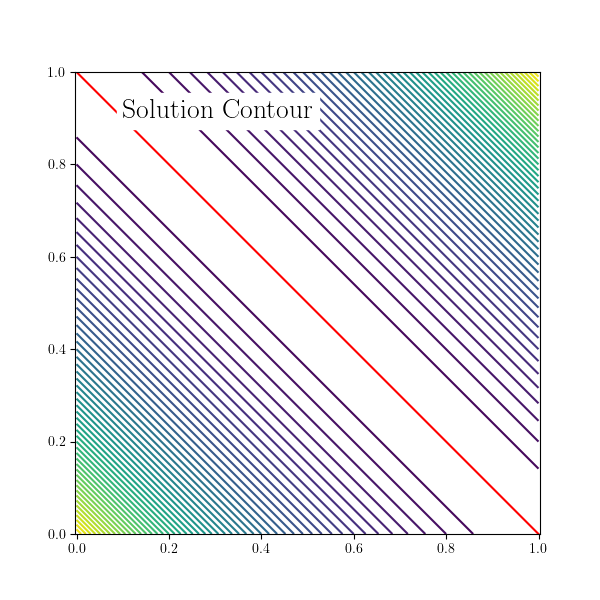

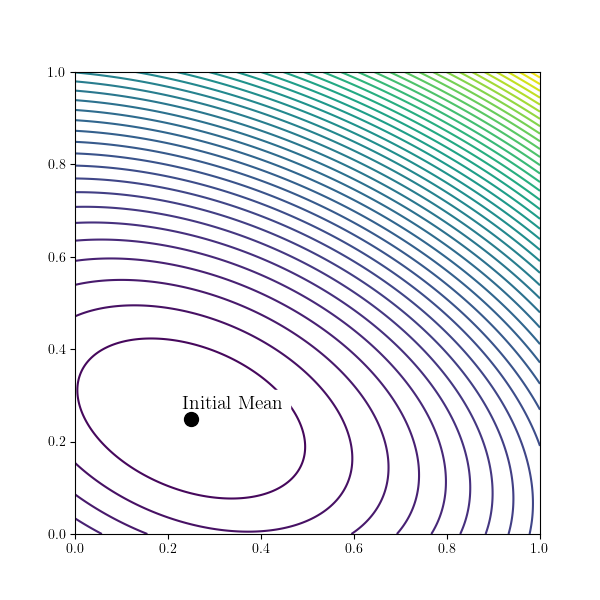

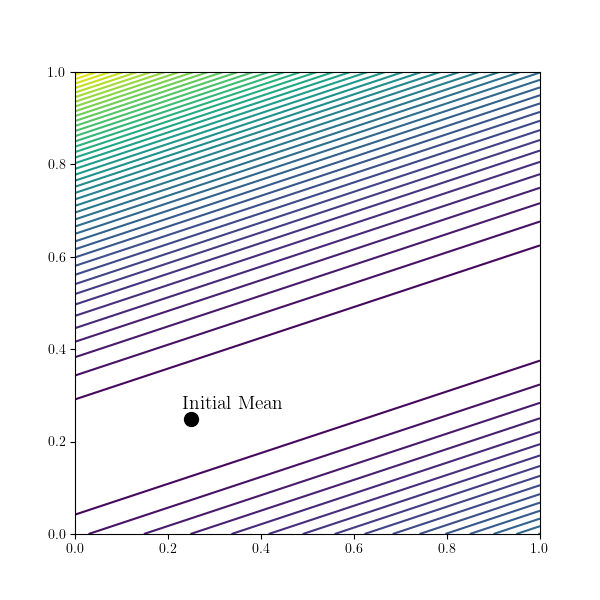

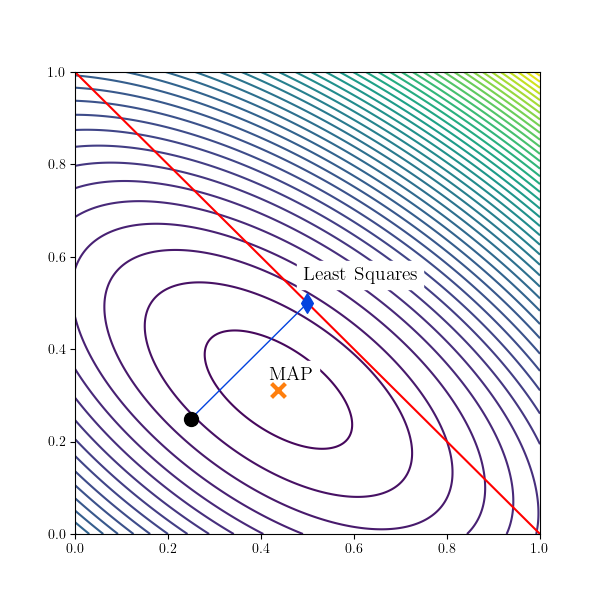

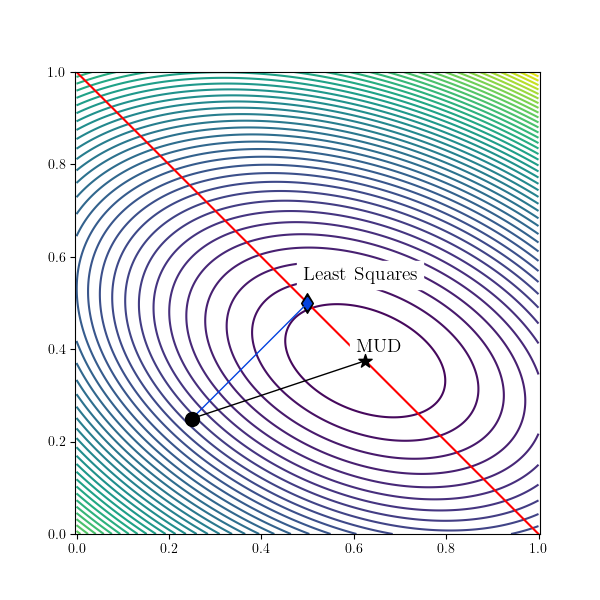

In [8]:
run_contours(close_fig=False)

### Comparing Functionals

1. Bayesian - Tikhonov regularization - Traditional solution, searching for value that minimizes residual but also without blowing up solution. 

$\Large T(\lambda) := || Q(\lambda) - \mathbf{y} || ^2_{\Sigma^{-1}_{obs}} + || \lambda-\lambda_0 || ^2_{\Sigma_{init}^{-1}}$

2. Data-Consistent - An extra term from Tikhanov reg, coming from the predicted density, to "unregularize" in drections that are informed by the data. So if large discrepancy between data and observations, term will be large.

$\Large J(\lambda) := T(\lambda) - || Q(\lambda) - Q(\lambda_0) || ^2_{\Sigma^{-1}_{pred}}$


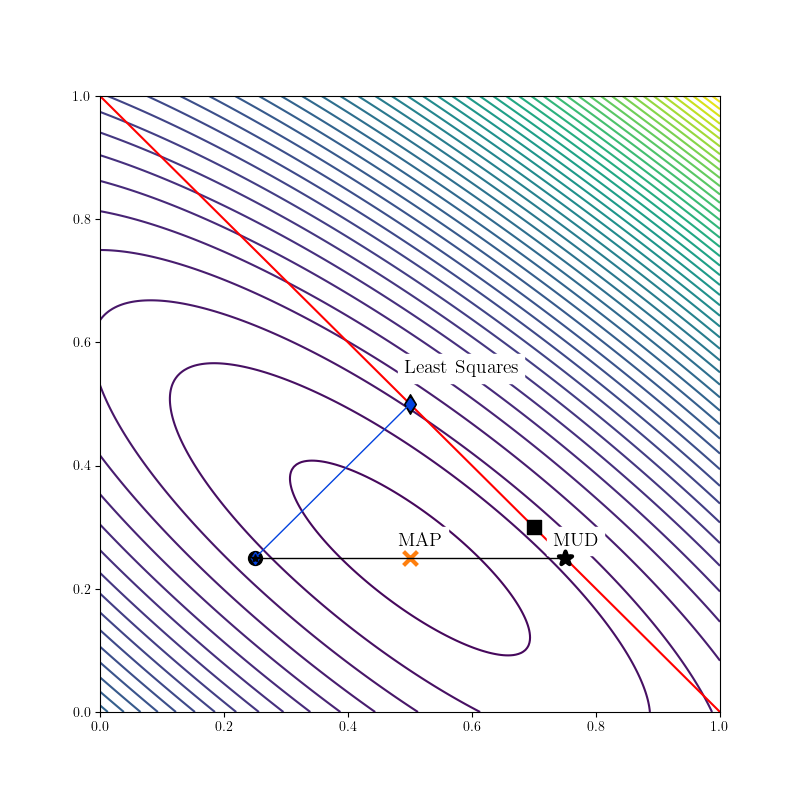

In [9]:
run_comparison_contours(close_fig=False)

## Existence and Uniqueness of MUD Points

Suppose  $Q(\lambda)=A\lambda+b$ for some full rank $A\in\mathbb{R}^{d\times p}$ with $d\leq p$ and $b\in\mathbb{R}^d$.
If $\initial \sim N(\lambda_0,\initialCov)$, $\observed\sim N(\observedMean,\observedCov)$, and the predictability assumption holds, then

1. There exists a unique parameter, denoted by $\mudpt$, that maximizes $\updated$.
2. $Q(\mudpt) = \observedMean$.
3. If $d=p$, $\mudpt$ is given by $A^{-1}$. If $d<p$, $\mudpt$ is given by~\eqref{eq:mud-point-analytical-final} and the covariance associated with this point is given by~\eqref{eq:updatedCov_final}.


If $\initial \sim N(\param_0,\initialCov)$ and data are obtained for $d$ linearly independent measurements on $\pspace$ with an additive noise model with1G i.i.d. Gaussian noise for each measurement, then
\begin{enumerate}[(a)]
\item There exists a minimum number of data points obtained for each of the measurements such that there exists a unique $\mudpt$ and $Q_\text{WME}(\mudpt) = 0$.
\item The variance in the $\mudpt$ estimate in $d$ directions of the parameter space decreases at a rate proportional to the number of data points used for each of the measurements.

## Spectral Properties of Updtaed Covariance for WME Map

We illustrate the result in the above corollary with an example that highlights how the number of distinct measurements used to form $Q$ impacts the spectrum of the updated covariance.
Consider a randomly generated linear operator $M$ of dimension $5 \times 20$ with components sampled from a $N(0,1)$ distribution.
This $M$ defines five randomly constructed, but geometrically distinct (i.e., linearly independent), measurements.
We then construct the QoI by simulating repeated measurements $N=10, 100, 1000, 10000$ (for each measurement) polluted by additive Gaussian noise with $\sigma=0.1$.
We then compute the updated covariance using the analytical expression (eq. 24) 

$$
\newcommand{\initialCov}{\Sigma_\text{init}}
\newcommand{\observedCov}{\Sigma_\text{obs}}
\newcommand{\predictedCov}{\Sigma_\text{pred}}
\newcommand{\updatedCov}{\Sigma_\text{up}}
\newcommand{\initialMean}{\param_0}
\updatedCov = \initialCov - \initialCov A^\top \predictedCov^{-1}\left[\predictedCov-\observedCov\right]\predictedCov^{-1}A\initialCov.
$$

and perform a singular value decomposition to obtain the $20$ sorted eigenvalues, which we plot for each $N$.

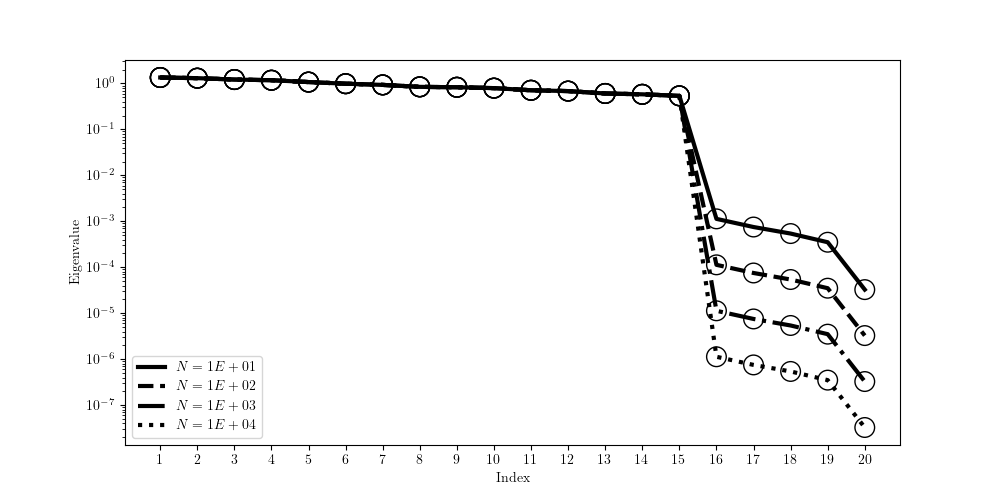

In [10]:
run_wme_covariance_example(close_fig=False)

# Higher-Dimensional Linear Gaussian Examples

This notebook is intended to supplement [ref] section 4 on numerical comparisons of MUD, MAP, and Least Squares solutions to the Linear Gaussian problem as the dimension of the problem increases. 


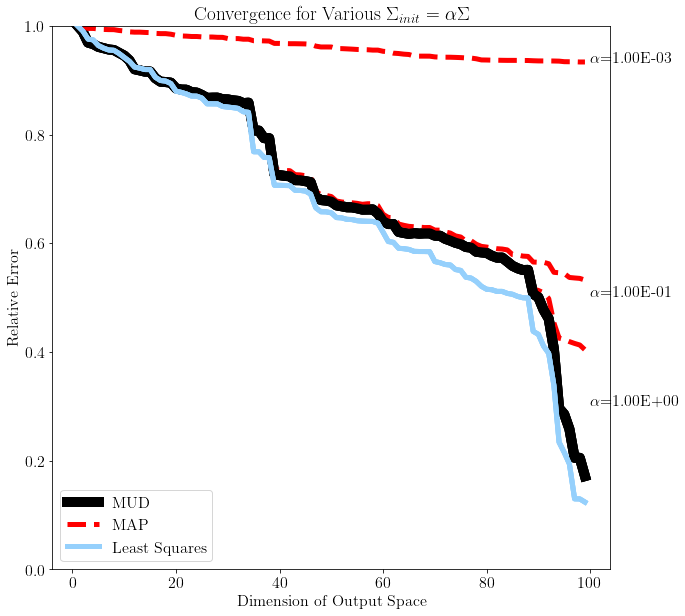

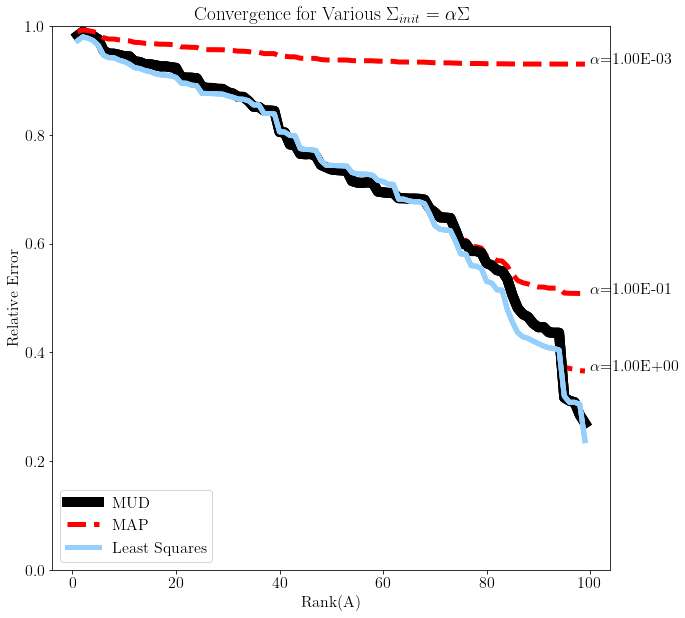

In [5]:
run_high_dim_linear(close_fig=False)

# Data-Constructed QoI Maps II: Data Clouds and Principle Component Analysis

This notebook is intended to supplement [ref] section 5 where data-constructed Quantity of Interest (QoI) Maps are explored.

# Spatial and Temporal Data Examples

The Weighted Mean Error Map in section 3 (ref equation) was introduced as a way to incorporate data into the parameter identification problem in order to reduce the variance as more data is incorporated, with corollary (ex) showing how, in the linear gaussian case, we were guaranteed to reach a unique MUD point after incorporating enough data. Furthermore in example [ref] we saw how, for a simple non-linear map $Q(\lambda) = \lambda^5$, we were able to incorporate repeated measurements into the $Q_WME$ map to effectively reduce variance in our MUD estimate as more data was incorporated. 

The question now becomes, how do we incorporate data into the the WME map when the data collected is not from repeated measurements - that is we have multiple sensors collecting data over a spatial and/or time domain, such that correlations exist between measurements taken? The construction of the WME map was based off the argument of statistical sufficiency with the assumptions of a repeated measurement case, taking an equally weighted average of the residuals since they are assumed to be uncorrelated. It is unlikely that this equal waiting will be the most efficient way of encoding the variability in the observed data in the general spatio-temporal measurement case. Consider an exponential decay system, where the uncertain parameter is the initial quantity of material being present. It is intuitive enough that data from initial time-steps of the system as opposed to data from time-steps when there is very little material left, will be the most important to determining the initial condition of the system. Thus we need a way of decorrelating the data cloud of spatio-temporal data to extract the maximum variability in the data set when constructing the $Q$ map based off of residuals. 

For this we turn to the ubiquitous and popular Principal Component Analysis PCA. Introduced first by [Pearson and Hotelling refs], Principal Component Analysis, or PCA, is a way to reduce dimensionality of a large set of correlated data by transforming the data into a new set of variables known as Principal Components, which are uncorrelated and which, when ordered, contain the maximum amount of variation in the data per component [re-word this]. The PCA has been used in a wide variety of applications such as _____ and is known by many different names, including ____. 

TODO: Using truncated PCA. PCA equation and $Q_PCA$ equation. Address how no more $1/\sqrt(N)$ term and now instead $1/||\alpha_i||$ now instead for each principle component. Also note how the $Q_PCA$ map will have as man ycomponents as 

In the following examples we explore how the $Q_{PCA}$ map can effectively incorporate spatio-temporal data for the PIP in the case of two non-linear inversion problems. In both examples the PCA method effectively produces a better $Q$ map to invert leading to better parameter estimates.

## Spatial Data Example: Poisson’s Equation with Uncertain Boundary Condition

We begin by first considering the aggregation of data over a spatial domain. In this problem, the uncertain model parameter is now described by an unknown function defining the boundary data to a stationary PDE.

Consider the Poisson problem:

$$
\begin{cases}
\hfill -\nabla \cdot \nabla u &= f(x), \quad\text{on } x\in \Omega, \\
\hfill u &= 0, \quad\text{ on } \Gamma_T \cup \Gamma_B, \\
\hfill \frac{\partial u}{\partial \mathbf{n}} &= g(x_2), \quad\text{ on } \Gamma_L, \\
\hfill \frac{\partial u}{\partial \mathbf{n}} &= 0, \quad\text{ on } \Gamma_R,
\end{cases}
$$

where $x=(x_1, x_2) \in \Omega = (0,1)^2$ is the spatial domain; $\Gamma_T$, $\Gamma_B$, $\Gamma_L$, and $\Gamma_R$, denote the top, bottom, left, and right boundaries of this domain, respectively, and $\frac{\partial u}{\partial \mathbf{n}}$ denotes the usual outward normal derivative.
The forcing function $f$ is taken to be $10\exp\left ( ||x - 0.5||^2 / 0.02 \right )$.

Here, we assume that $g(x_2)$ is unknown, and the goal is to use noisy data to estimate this unknown boundary data.
In other words, the parameter $\lambda$ now represents an uncertain function.
To generate the noisy data, we use a reference $g(x_2)\propto x_2^2(x_2-1)^5$ with a constant of proportionality chosen to produce a minimum of $-3$ at $x_2=\frac{2}{7}$.
Then, we compute a reference solution using piecewise-linear finite elements on a triangulation of a $36\times36$ mesh.
Random noise is then added to every degree of freedom of this reference solution, and the spatial data are subsequently computed from a fixed set of 100 randomly placed sensors in the subdomain $(0.05, 0.95)^2 \subset \Omega$.
This process is repeated $20$ times to study the subsequent variation in MUD points due to different realizations of noisy data.

To construct a finite-dimensional parameter space describing the initial uncertainty of $g(x_2)$, we first assume that it is known that $g$ is non-positive and bounded below by $-4$.
We further assume that $g$ is smooth enough to be reasonably approximated by a piecewise-linear continuous spline with four knots and that $g(0)=g(1)=0$.
Thus, the uncertainty is described by the values of the splines at the two interior knot points chosen as the equispaced points $1/3$ and $2/3$.
This defines a finite-dimensional parameter space described by $\Lambda = [-4,0]^2$.
We generate $1000$ samples from an initial uniform density on $\Lambda$ to (1) generate random spline functions and compute the (noise-free) data from solutions associated with these splines; and (2) estimate the push-forward and updated densities along with the MUD estimate of $g(x_2)$.
These same $1000$ samples are used across all $20$ realizations of random noisy data.

In [9]:
import numpy as np
import scipy.stats.distributions as ds
import matplotlib.pyplot as plt

from mud.base import DensityProblem

import mud_examples.poisson as ps


ModuleNotFoundError: No module named 'mud_examples'

In [7]:
sample_dist = "u"
input_dim = 2
prefix = 1000
fname = f"../data/ref_{prefix}_{input_dim}{sample_dist}.pkl"

P = ps.pdeProblem(fname)
P.load()
if sample_dist == "n":
    P.dist = ds.norm  # required for generator functions
    loc = -2.0
    scale = 0.2
else:
    P.dist = ds.uniform
    loc = -4.0
    scale = 4.0

NameError: name 'ps' is not defined

In [48]:
import pickle 
import pathlib
import mud.base as base
from mud.base import SpatioTemporalProblem
from mud.util import std_from_equipment
import importlib

importlib.reload(base)

<module 'mud.base' from '/Users/carlos/repos/mud/src/mud/base.py'>

In [44]:
fname = Path.cwd() / f"../data/ref_1000_2u.pkl"
with open(fname, 'rb') as fp:
    data = pickle.load(fp)
data.keys()

dict_keys(['sensors', 'lam', 'qoi', 'truth', 'data', 'plot_u', 'plot_g'])

In [45]:
len(data['data'])

500

In [49]:
poisson_prob = base.SpatioTemporalProblem()
poisson_prob.load(str(fname),
        lam="lam",
        data="qoi",
        true_vals=None,
        measurements="data",
        std_dev=0.05,
        sample_dist="uniform",
        domain=[[-4,0],[-4,0]],
        lam_ref=None,
        sensors="sensors",
        time=None,
    )

AttributeError: 'SpatioTemporalProblem' object has no attribute 'n_params'

Text(0, 0.5, '$x_2$')

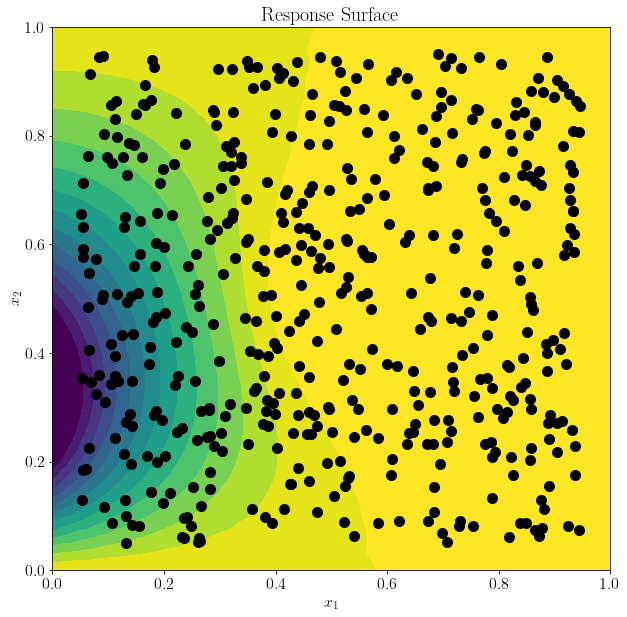

In [22]:
fsize = 16
plt.figure(figsize=(10, 10))
colors = ["xkcd:red", "xkcd:black", "xkcd:orange", "xkcd:blue", "xkcd:green"]

sensors = data["sensors"]
coords, vals = data["plot_u"]
plt.tricontourf(coords[:, 0], coords[:, 1], vals, levels=20, vmin=-0.5, vmax=0)
plt.title("Response Surface", fontsize=1.25 * fsize)
plt.scatter(sensors[:, 0], sensors[:, 1], s=100, color="xkcd:black")

#
#     plt.scatter([0] * num_qoi, intervals, s=500, marker="^", c="w")
# if num_sensors is not None:  # plot sensors
#     intervals = np.linspace(0, 1, num_qoi + 2)[1:-1]
#     if mode == "sca":
#         qoi_indices = band_qoi(sensors, 1, axis=1)
#         _intervals = (
#             np.array(intervals[1:])
#             + (np.array(intervals[:-1]) - np.array(intervals[1:])) / 2
#         )
# 
#     elif mode == "hor":
#         qoi_indices = band_qoi(sensors, num_qoi, axis=1)
#         # partitions equidistant between sensors
#         _intervals = (
#             np.array(intervals[1:])
#             + (np.array(intervals[:-1]) - np.array(intervals[1:])) / 2
#         )
# 
#     elif mode == "ver":
#         qoi_indices = band_qoi(sensors, num_qoi, axis=0)
#         # partitions equidistant on x_1 = (0, 1)
#         _intervals = np.linspace(0, 1, num_qoi + 1)[1:]
#     else:
#         raise ValueError(
#             "Unsupported mode type. Select from ('sca', 'ver', 'hor'). "
#         )
#     for i in range(0, len(qoi_indices)):
#         _q = qoi_indices[i][qoi_indices[i] < num_sensors]
#         plt.scatter(sensors[_q, 0], sensors[_q, 1], s=100, color=colors[i % 2])
#         if i < num_qoi - 1:
#             if mode == "hor":
#                 plt.axhline(_intervals[i], lw=3, c="k")
#             elif mode == "ver":
#                 plt.axvline(_intervals[i], lw=3, c="k")
# 
#     plt.scatter([0] * num_qoi, intervals, s=500, marker="^", c="w")
# 
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

# 
# num_qoi = 2
# plot_without_fenics(
# data,
# num_sensors=100,
# mode="hor",
# num_qoi=num_qoi,
# example="mud",  # TODO: rename this variable
# )

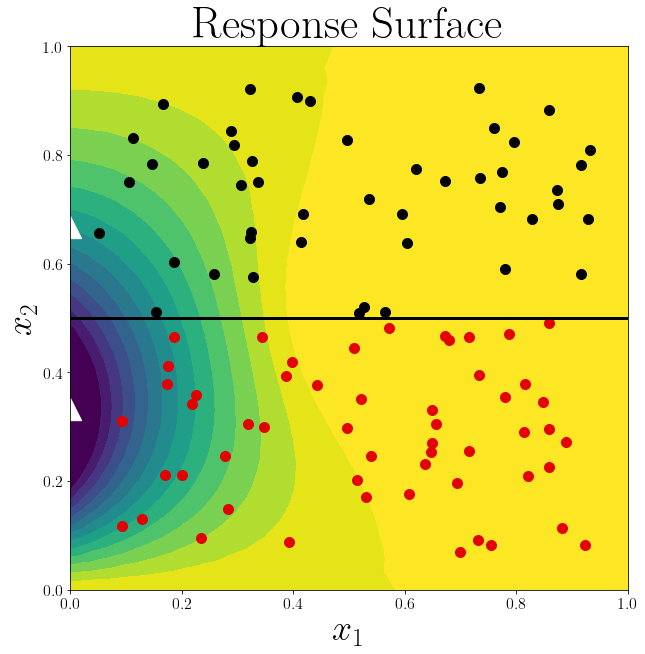

In [6]:
# probably move to helpers or utils
def band_qoi(sensors, num_qoi=1, axis=1):
    intervals = np.linspace(0, 1, num_qoi + 2)[1:-1]
    if axis == 1:
        _intervals = (
            np.array(intervals[1:])
            + (np.array(intervals[:-1]) - np.array(intervals[1:])) / 2
        )
    elif axis == 0:
        _intervals = np.linspace(0, 1, num_qoi + 1)[1:]
    else:
        raise ValueError("axis must be 0 or 1 since the example is in 2D")
    _intervals = [0] + list(_intervals) + [1]
    qoi_indices = [
        np.where(
            np.logical_and(
                sensors[:, axis] > _intervals[i], sensors[:, axis] < _intervals[i + 1]
            )
        )[0]
        for i in range(num_qoi)
    ]
    return qoi_indices

# modify this method for new plot based on singular vectors
def plot_without_fenics(
    ref, num_sensors=None, num_qoi=2, mode="sca", fsize=36, example=None
):
    plt.figure(figsize=(10, 10))
    mode = mode.lower()
    colors = ["xkcd:red", "xkcd:black", "xkcd:orange", "xkcd:blue", "xkcd:green"]


    sensors = ref["sensors"]
    coords, vals = ref["plot_u"]
    plt.tricontourf(coords[:, 0], coords[:, 1], vals, levels=20, vmin=-0.5, vmax=0)
    plt.title("Response Surface", fontsize=1.25 * fsize)
    if num_sensors is not None:  # plot sensors
        intervals = np.linspace(0, 1, num_qoi + 2)[1:-1]
        if mode == "sca":
            qoi_indices = band_qoi(sensors, 1, axis=1)
            _intervals = (
                np.array(intervals[1:])
                + (np.array(intervals[:-1]) - np.array(intervals[1:])) / 2
            )

        elif mode == "hor":
            qoi_indices = band_qoi(sensors, num_qoi, axis=1)
            # partitions equidistant between sensors
            _intervals = (
                np.array(intervals[1:])
                + (np.array(intervals[:-1]) - np.array(intervals[1:])) / 2
            )

        elif mode == "ver":
            qoi_indices = band_qoi(sensors, num_qoi, axis=0)
            # partitions equidistant on x_1 = (0, 1)
            _intervals = np.linspace(0, 1, num_qoi + 1)[1:]
        else:
            raise ValueError(
                "Unsupported mode type. Select from ('sca', 'ver', 'hor'). "
            )
        for i in range(0, len(qoi_indices)):
            _q = qoi_indices[i][qoi_indices[i] < num_sensors]
            plt.scatter(sensors[_q, 0], sensors[_q, 1], s=100, color=colors[i % 2])
            if i < num_qoi - 1:
                if mode == "hor":
                    plt.axhline(_intervals[i], lw=3, c="k")
                elif mode == "ver":
                    plt.axvline(_intervals[i], lw=3, c="k")

        plt.scatter([0] * num_qoi, intervals, s=500, marker="^", c="w")
        
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("$x_1$", fontsize=fsize)
    plt.ylabel("$x_2$", fontsize=fsize)


num_qoi = 2
plot_without_fenics(
    data,
    num_sensors=100,
    mode="hor",
    num_qoi=num_qoi,
    example="mud",  # TODO: rename this variable
)

### Baseline Solution

In [31]:
# generator function which takes (num_obs, sd) as arguments and returns a mud_problem
mud_generator = P.mud_vector_horizontal(num_qoi, loc=loc, scale=scale)

In [32]:
mud_problem = mud_generator(500, 0.01) # simulates noisy measurements

In [33]:
mud_problem

In [34]:
mud_problem.mud_point()

array([-3.19450497, -0.44650169])

### Reference Solution

In [35]:
# TODO : turn this snippet into a method
closest_fit_index_out = np.argmin(
    np.linalg.norm(P.qoi - np.array(P.qoi_ref), axis=1)
)
g_projected = P.lam[closest_fit_index_out, :].ravel()
lam_true = g_projected
print(lam_true)

[-3.19450497 -0.44650169]


### SVD Approach

In [36]:
num_obs = 500
sd = 0.05
measure_true = P.qoi_ref[0:num_obs]
measurements = P.qoi[:, 0:num_obs]
noise = np.random.randn(num_obs) * sd
data = measure_true + noise
# q = wme(qoi, data, sd).reshape(-1, 1)

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scalar = StandardScaler()

In [39]:
residuals = (measurements - data) / sd
X = scalar.fit_transform(residuals)

In [40]:
U, singular_values, singular_vectors = np.linalg.svd(X)

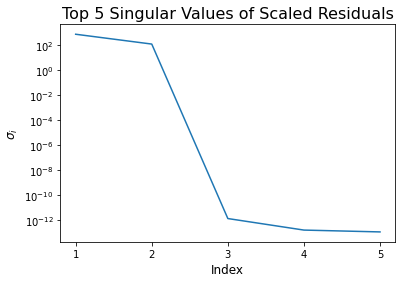

In [41]:
top_singular_values = 5
inds = np.arange(1, top_singular_values+1)
plt.plot(inds, singular_values[0:top_singular_values])
plt.xticks(inds)
plt.xlabel("Index", fontsize=12)
plt.ylabel("$\sigma_i$", fontsize=12)
plt.yscale('log')
plt.title(f"Top {top_singular_values} Singular Values of Scaled Residuals", fontsize=16)
plt.show()

In [42]:
scalar = StandardScaler()
S = scalar.fit_transform(singular_vectors)

/var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_39040/3703693558.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


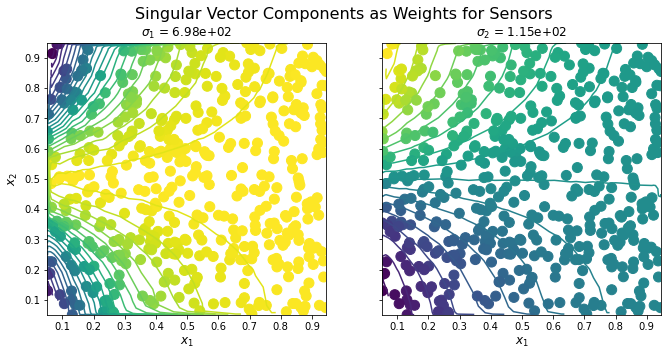

In [43]:
top_singular_vectors = 2
fig, ax = plt.subplots(1, top_singular_vectors, figsize=(1+5*top_singular_vectors, 5), sharey=True)
for i in range(top_singular_vectors):
    ax[i].tricontour(P.sensors[0:num_obs, 0], P.sensors[0:num_obs, 1], singular_vectors[i, :], levels=20, alpha=1)
    ax[i].scatter(P.sensors[0:num_obs, 0], P.sensors[0:num_obs, 1], s=100, c=singular_vectors[i, :])
    ax[i].set_title(f"$\sigma_{i+1}$ = {singular_values[i]:1.2e}")
    ax[i].set_xlabel("$x_1$", fontsize=12)
    if i == 0: ax[i].set_ylabel("$x_2$", fontsize=12)
fig.suptitle("Singular Vector Components as Weights for Sensors", fontsize=16)
fig.show()

/var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_39040/2174438493.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


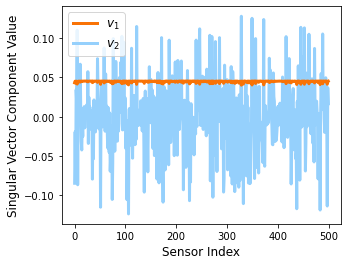

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
# plt.plot((singular_vectors[0, :] + singular_vectors[1, :]))
ax.plot(singular_vectors[0, :], c='xkcd:orange', label="$v_1$", lw=3)
ax.plot(singular_vectors[1, :], c='xkcd:light blue', label="$v_2$", lw=3, zorder=0)
ax.legend(fontsize=12)
ax.set_xlabel("Sensor Index", fontsize=12)
ax.set_ylabel("Singular Vector Component Value", fontsize=12)
fig.show()

In [45]:
# fig, ax = plt.subplots(figsize=(3,3))
# ax.scatter(P.sensors[0:num_obs, 0], P.sensors[0:num_obs, 1], s=100, c= (singular_vectors[0, :] + singular_vectors[1, :]))
# fig.show()

In [46]:
num_qoi = 2
new_qoi_map = singular_vectors[0:num_qoi, :]
new_qoi = residuals @ new_qoi_map.T  # ok shape, wrong solution, identical to using U@sigma

In [47]:
ax.contour

<bound method Axes.contour of <AxesSubplot:xlabel='Sensor Index', ylabel='Singular Vector Component Value'>>

/var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_39040/3247924399.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


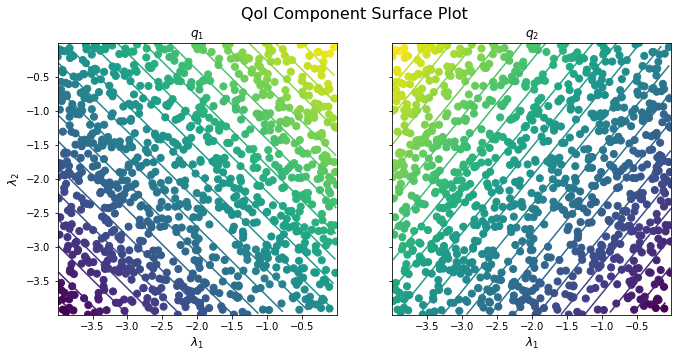

In [48]:
top_singular_vectors = 2
fig, ax = plt.subplots(1, top_singular_vectors, figsize=(1+5*top_singular_vectors, 5), sharey=True)
for i in range(top_singular_vectors):
    ax[i].scatter(P.lam[:,0], P.lam[:,1], s=50, c=new_qoi[:,i])
    ax[i].tricontour(P.lam[:,0], P.lam[:,1], new_qoi[:,i], levels=20)
#     ax[i].set_title(f"$\sigma_{i}$ = {singular_values[i]:1.2e}")
    ax[i].set_title(f"$q_{i+1}$", fontsize=12)
    ax[i].set_xlabel("$\lambda_1$", fontsize=12)
    if i == 0: ax[i].set_ylabel("$\lambda_2$", fontsize=12)
# fig.supylabel("$\lambda_2$")
fig.suptitle("QoI Component Surface Plot", fontsize=16)
fig.show()

In [24]:
d = DensityProblem(P.lam, new_qoi, P.domain, weights=None)
print(d.mud_point())

[-3.33481859 -0.4281153 ]


In [38]:
data.keys()

dict_keys(['sensors', 'lam', 'qoi', 'truth', 'data', 'plot_u', 'plot_g'])

In [8]:
def plot(
    data,
    sols=None,
    num_measurements=20,
    example="mud",
    fsize=36,
    ftype="png",
    save=False,
):
    lam = data['lam']
    qoi = data['qoi']
    qoi_ref = data['data']
    # dist = self.dist
    fname = 'test'
    # fname = fname.replace('data/', '')
    fname = "figures/" + fname
    check_dir(fname)
    closest_fit_index_out = np.argmin(
        np.linalg.norm(qoi - np.array(qoi_ref), axis=1)
    )
    g_projected = list(lam[closest_fit_index_out, :])
    plt.figure(figsize=(10, 10))

    g_mesh, g_plot = g
    intervals = list(np.linspace(0, 1, lam.shape[1] + 2)[1:-1])
    # fin.plot(u_plot, mesh=mesh, lw=5, c='k', label="$g$")
    plt.plot(g_mesh, g_plot, lw=5, c="k", label="$g$")
    plt.plot(
        [0] + intervals + [1],
        [0] + g_projected + [0],
        lw=5,
        c="green",
        alpha=0.6,
        ls="--",
        label="$\\hat{g}$",
        zorder=5,
    )

    if sols is not None:
        if sols.get(num_measurements, None) is None:
            raise AttributeError(
                f"Solutions `sols` missing requested N={num_measurements}. `sols`={sols!r}"
            )
        else:
            prefix = f"{fname}/{example}_solutions_N{num_measurements}"
            plot_lam = np.array(sols[num_measurements])
            if example == "mud-alt":
                qmap = "$Q_{%dD}^\\prime$" % lam.shape[1]
                soltype = "MUD"
            elif example == "mud":
                qmap = "$Q_{%dD}$" % lam.shape[1]
                soltype = "MUD"
            elif example == "map":
                qmap = "$Q_{1D}$"
                soltype = "MAP"
            else:
                raise ValueError("Unsupported example type.")
            plt.title(
                f"{soltype} Estimates for {qmap}, $N={num_measurements}$",
                fontsize=1.25 * fsize,
            )
    else:  # initial plot, first 100
        # prefix = f'pde_{lam.shape[1]}{dist}/initial'
        prefix = f"{fname}/{example}_initial_S{lam.shape[0]}"
        plot_lam = lam[0:100, :]
        plt.title("Samples from Initial Density", fontsize=1.25 * fsize)

    for _lam in plot_lam:
        plt.plot(
            [0] + intervals + [1],
            [0] + list(_lam) + [0],
            lw=1,
            c="purple",
            alpha=0.2,
        )

    plt.xlabel("$x_2$", fontsize=fsize)
    plt.ylabel("$g(x, \\lambda)$", fontsize=fsize)

    # label min(g)
    # plt.axvline(2/7, alpha=0.4, ls=':')
    # plt.axhline(-lam_true, alpha=0.4, ls=':')
    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend()
    if save:
        _fname = f"{prefix}.{ftype}"
        plt.savefig(_fname, bbox_inches="tight")
        _logger.info(f"Saved {_fname}")
        plt.close("all")

#     plt.show()


plot(data)
plt.show()
    

NameError: name 'check_dir' is not defined

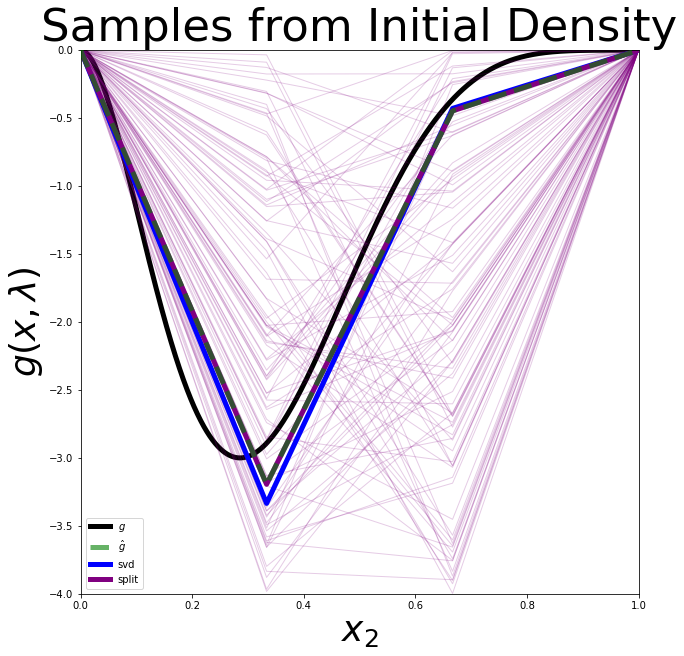

In [25]:
P.plot()
plt.plot(np.linspace(0, 1, input_dim + 2), [0] + list(d.mud_point()) + [0], lw=5, c='blue', label='svd')
plt.plot(np.linspace(0, 1, input_dim + 2), [0] + list(mud_problem.mud_point()) + [0], lw=5, c='purple', label='split')
plt.legend()
plt.show()

## Temporal Data Example: ADCIRC with Uncertain Wind Drag